### Deep Learning Notes 5
- *Автор*: Зитцер Данил
- *Дата*: понедельник, 22 февраля 2021 г., 08:37:50
- *Описание*: Познакомимся со свёрточными нейронными сетями, которые предназначены для работы задачами компьютерного зрения.
- *План блокнота*:
    1. Тренировка полносвязной нейронной сети для умения различать круги от квадратов
        - создание генератора данных
        - решение задачи как задачи бинарной классификации
        - решение задачи как задачи с пересекающимися классами
        - решение задачи как задачи многоклассовой классификации
        - недостатки полносвязных сетей при работе с изображениями
    2. Введение в свёрточные нейронные сети
        - типы задач компьютерного зрения
        - операция свёртки
        - операция пулинга
        - решение задачи Fashion MNIST простой свёрточной нейронной сетью
    3. Техники визуализации знаний нейронных сетей
    4. Adversarial attacks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams['font.size'] = 20

Этот блок скорей всего вам нужно будет пропустить. 

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
# разрешить рост потребления памяти при необходимости
config.gpu_options.allow_growth = True
# создать сессию с указанными выше опциями
session = InteractiveSession(config=config)

### Полносвязные нейронные сети

![](https://www.researchgate.net/profile/Charlotte_Pelletier/publication/331525817/figure/fig2/AS:733072932745216@1551789615161/Example-of-fully-connected-neural-network.png)

#### Генерация набора данных

In [3]:
from skimage import draw

In [4]:
def random_figure_generator():
    ''' Возвращает изображение 100 на 100, чередуя квадраты и круги '''
    is_rectangle = False
    
    while True:       
        # прямоугольник -> круг -> прямоугольник -> круг -> ....
        is_rectangle = not is_rectangle
        
        image = np.zeros(shape=(100, 100), dtype=np.uint8)

        if is_rectangle:
            size = np.random.randint(low=5, high=45, dtype=np.uint8)

            rr, cc = draw.rectangle_perimeter(
                start=(50 - size, 50 - size),
                end=(50 + size, 50 + size),
                shape=(100, 100),
            )
        else:
            rr, cc = draw.circle_perimeter(
                r=50,
                c=50,
                radius=np.random.randint(low=5, high=45, dtype=np.uint8),
                shape=(100, 100),
            )

        image[rr, cc] = 255

        yield image, is_rectangle

In [5]:
figure_gen = random_figure_generator()

Text(0.5, 1.0, 'True')

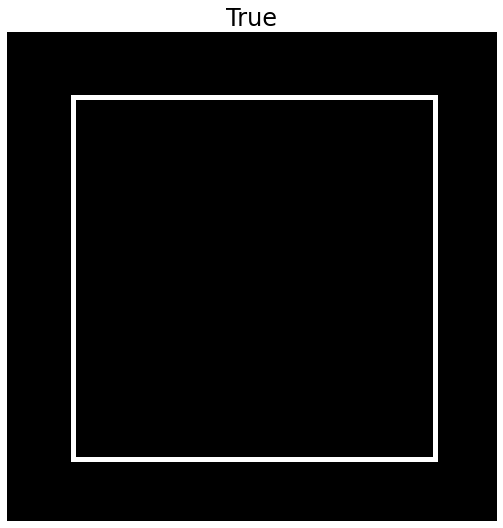

In [6]:
image, label = next(figure_gen)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(label)

Обернём наш генератор в tf.data.Dataset

[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Конвеер трансформации исходных данных во входные данные нейронной сети

In [7]:
ds = tf.data.Dataset.from_generator(
    generator=random_figure_generator,
    output_signature=(
        tf.TensorSpec(shape=(100, 100), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

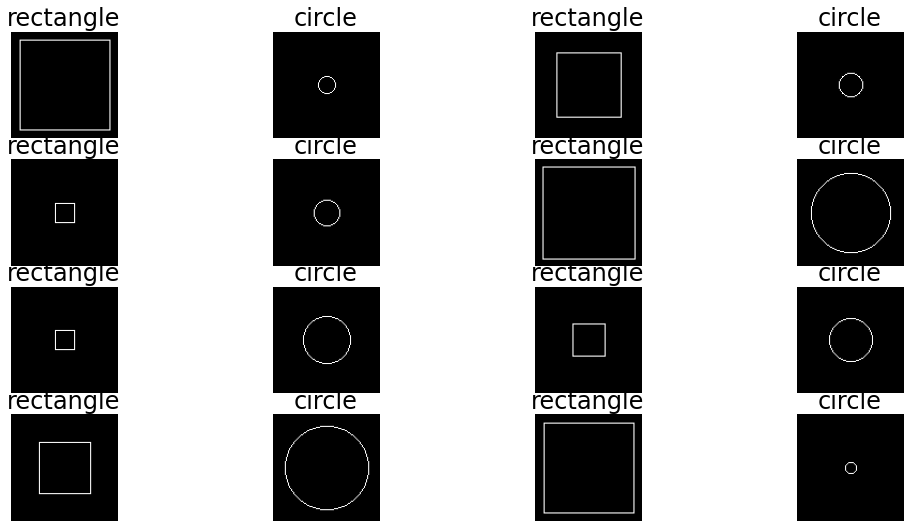

In [8]:
ds_iter = iter(ds)

label_mapping = {0: 'circle', 1: 'rectangle'}

fig, axes = plt.subplots(4, 4)

for ax in axes.flat:
    image, label = next(ds_iter)
    ax.imshow(image, cmap='gray')
    ax.set_title(label_mapping[label.numpy()])
    ax.axis('off')

#### Архитектура модели

С лосс-функциями всё просто: она подбирается в зависимости от функции активации на последнем слое.

![](https://miro.medium.com/max/1858/1*IhP8BdoUpAbssltq0VBafg.png)

**ВНИМАНИЕ!**

In [9]:
loss_mapping = {
    'sigmoid': 'binary_crossentropy',
    'softmax': 'categorical_crossentropy',
}

def build_model(units: int, activation: str):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(100, 100), name='input_layer'))
    model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, name='rescaling_layer'))
    model.add(layers.Flatten(name='flatten_layer'))
    model.add(layers.Dense(units=units, activation=activation, name='dense_layer'))

    model.compile(
        optimizer='sgd',
        loss=loss_mapping[activation],
        metrics=[
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
        ]
    )

    return model

**СКОЛЬКО БУДЕТ ПАРАМЕТРОВ У МОДЕЛЕЙ С 1 ИЛИ 2 НЕЙРОНАМИ?**

#### Модель, предсказывающая вероятность прямоугольника (бинарная классификация)

Модель: один нейрон и функция активации сигмоида.

Возвращает вероятность нахождения на изображении квадрата.

In [10]:
model = build_model(units=1, activation='sigmoid')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 14s 13ms/step - loss: 0.5668 - precision: 0.7810 - recall: 0.8196 - val_loss: 0.3806 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
1024/1024 [==============================] - 13s 13ms/step - loss: 0.3471 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2643 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1024/1024 [==============================] - 13s 13ms/step - loss: 0.2518 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2102 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 13s 13ms/step - loss: 0.1981 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1665 - val_precision: 1.0000 - val_recall: 1.0000


In [12]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(len(weights))
print(len(bias))

10000
1


**ВНИМАНИЕ!**

(-0.5, 99.5, 99.5, -0.5)

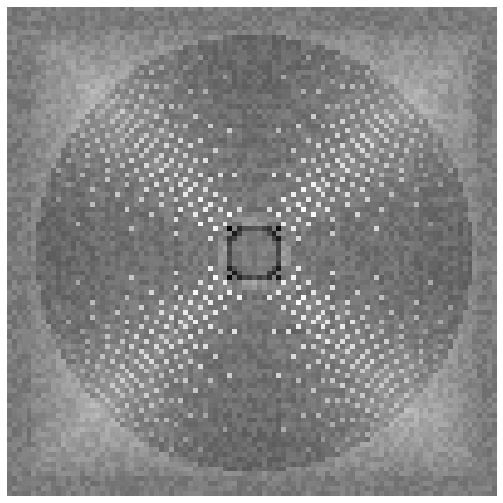

In [13]:
plt.imshow(weights.reshape(100, 100), cmap='gray')
plt.axis('off')

**ИНТЕРПРЕТИРУЙТЕ РЕЗУЛЬТАТ?**

#### Модель, предсказывающая вероятности и для прямоугольника, и для круга (пересекающиеся классы)

**ВНИМАНИЕ!**

Модель: два нейрона и функция активации сигмоида.

Возвращает отдельно вероятности нахождения на изображении квадрата и круга.

In [14]:
model = build_model(units=2, activation='sigmoid')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 2)                 20002     
Total params: 20,002
Trainable params: 20,002
Non-trainable params: 0
_________________________________________________________________


**ЧТО НЕ ТАК НА ТЕКУЩИЙ МОМЕНТ С ВХОДНЫМИ ДАННЫМИ?**

In [15]:
image, label = next(iter(ds))

print(image.shape)
print(label.shape)

(100, 100)
()


In [16]:
label

<tf.Tensor: shape=(), dtype=int32, numpy=1>

![](https://miro.medium.com/max/2474/1*ggtP4a5YaRx6l09KQaYOnw.png)

In [17]:
tf.equal(tf.range(2), label)

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([False,  True])>

In [18]:
ds = ds.map(lambda x, y: (x, tf.cast(tf.equal(tf.range(2), y), dtype=tf.float32)))

In [19]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 16s 15ms/step - loss: 0.6164 - precision: 0.7550 - recall: 0.7259 - val_loss: 0.4684 - val_precision: 0.9756 - val_recall: 0.9756
Epoch 2/4
1024/1024 [==============================] - 15s 15ms/step - loss: 0.4474 - precision: 0.9950 - recall: 0.9876 - val_loss: 0.3717 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1024/1024 [==============================] - 15s 15ms/step - loss: 0.3612 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3132 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 16s 15ms/step - loss: 0.3008 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2647 - val_precision: 1.0000 - val_recall: 1.0000


**ВНИМАНИЕ!**

In [20]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(len(weights))
print(len(bias))

10000
2


**ПОЧЕМУ СМЕЩЕНИЙ 2, А ВЕСОВ ВСЁ ТАК ЖЕ 10000?**

In [21]:
len([[1, 2], [3, 4], [5, 6]])

3

In [22]:
weights.shape

(10000, 2)

Text(0.5, 1.0, 'Rectangle weights\n')

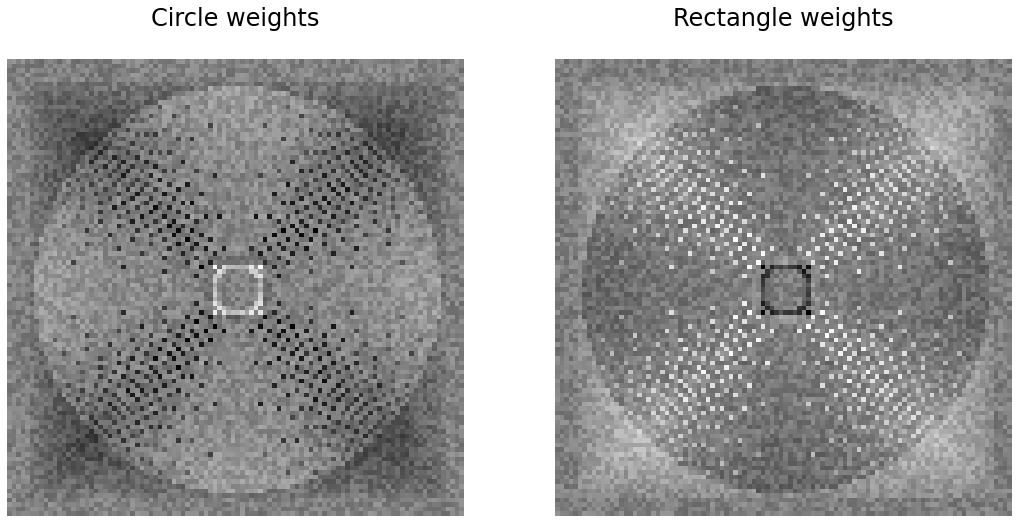

In [23]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(weights[:, 0].reshape(100, 100), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Circle weights\n')

axes[1].imshow(weights[:, 1].reshape(100, 100), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Rectangle weights\n')

**ВНИМАНИЕ!**

In [24]:
predictions = model.predict(ds.map(lambda x, y: x).batch(16).take(1))
predictions

array([[0.17543852, 0.8239571 ],
       [0.8211892 , 0.17944989],
       [0.32702303, 0.673407  ],
       [0.86602545, 0.13435169],
       [0.26792362, 0.7320453 ],
       [0.86602545, 0.13435169],
       [0.17543852, 0.8239571 ],
       [0.8121459 , 0.18856683],
       [0.17849104, 0.8207927 ],
       [0.6615418 , 0.3376982 ],
       [0.15305726, 0.84644425],
       [0.89588493, 0.10433892],
       [0.12729697, 0.87235403],
       [0.71382105, 0.28591824],
       [0.11323385, 0.88646317],
       [0.80011445, 0.20068361]], dtype=float32)

**ЧТО НЕ ТАК С ЭТИМИ ПРЕДСКАЗАНИЯМИ?**

In [25]:
predictions.sum(1)

array([0.9993956 , 1.0006391 , 1.0004301 , 1.0003772 , 0.9999689 ,
       1.0003772 , 0.9993956 , 1.0007128 , 0.99928373, 0.99924004,
       0.9995015 , 1.0002239 , 0.999651  , 0.9997393 , 0.999697  ,
       1.0007981 ], dtype=float32)

In [26]:
predictions.sum(1) == 1.0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

#### Модель, предсказывающая вероятности и для прямоугольника, и для круга (многоклассовая классификация)

Модель: два нейрона и функция активации софтмакс.

Возвращает взаимоисключающие вероятности квадрата и круга.

In [27]:
model = build_model(units=2, activation='softmax')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 2)                 20002     
Total params: 20,002
Trainable params: 20,002
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 16s 16ms/step - loss: 0.5102 - precision: 0.8541 - recall: 0.8541 - val_loss: 0.2677 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
1024/1024 [==============================] - 15s 15ms/step - loss: 0.2376 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1671 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1024/1024 [==============================] - 15s 15ms/step - loss: 0.1546 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1220 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 15s 15ms/step - loss: 0.1135 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0962 - val_precision: 1.0000 - val_recall: 1.0000


In [29]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(weights.shape)
print(bias.shape)

(10000, 2)
(2,)


Text(0.5, 1.0, 'Rectangle weights\n')

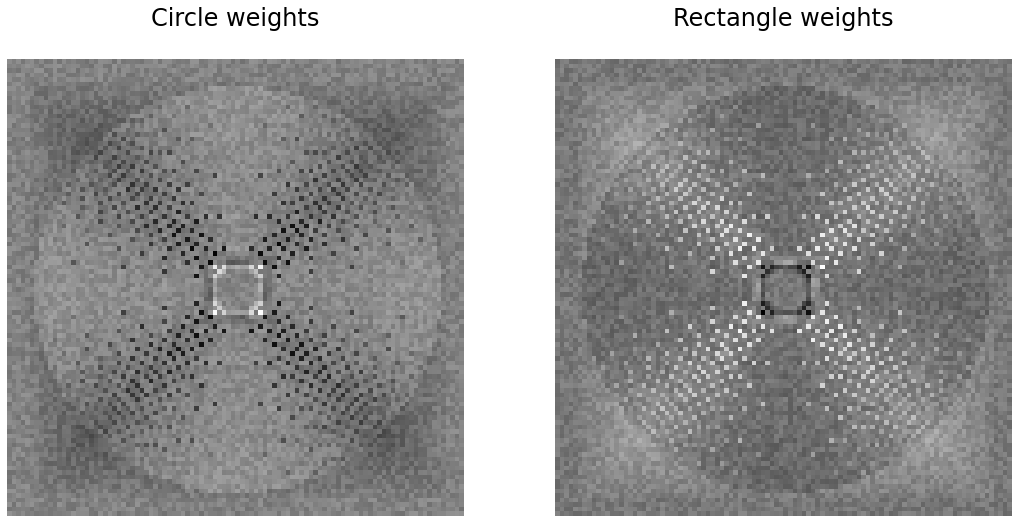

In [30]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(weights[:, 0].reshape(100, 100), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Circle weights\n')

axes[1].imshow(weights[:, 1].reshape(100, 100), cmap='gray')
axes[1].axis('off') 
axes[1].set_title('Rectangle weights\n')

In [31]:
predictions = model.predict(ds.batch(32).take(1))
predictions

array([[0.06065068, 0.9393493 ],
       [0.95186734, 0.04813261],
       [0.1500787 , 0.84992135],
       [0.97706497, 0.02293501],
       [0.03385903, 0.966141  ],
       [0.97730607, 0.02269389],
       [0.06358591, 0.93641406],
       [0.96886057, 0.03113944],
       [0.03044224, 0.96955776],
       [0.92879266, 0.0712074 ],
       [0.12268627, 0.87731373],
       [0.8837428 , 0.11625718],
       [0.17628379, 0.8237162 ],
       [0.9587448 , 0.04125516],
       [0.00971577, 0.99028426],
       [0.9251833 , 0.07481673],
       [0.03044224, 0.96955776],
       [0.85369545, 0.14630455],
       [0.06244462, 0.9375554 ],
       [0.92879266, 0.0712074 ],
       [0.04556983, 0.95443016],
       [0.9306816 , 0.06931841],
       [0.03020114, 0.96979886],
       [0.80496496, 0.19503504],
       [0.10284954, 0.89715046],
       [0.91441315, 0.08558683],
       [0.16786858, 0.83213145],
       [0.9657624 , 0.03423761],
       [0.22289126, 0.7771088 ],
       [0.8371672 , 0.16283274],
       [0.

In [32]:
predictions.sum(1)

array([1.        , 0.99999994, 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        ], dtype=float32)

#### Недостатки полносвязных нейронных сетей

cons:
- [полносвязные сети неинвариантны относительно сдвигов](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)
- зависимость количества параметров от размера входа

pros:
- [работа со структурированными данными](https://playground.tensorflow.org)



### Свёрточные нейронные сети

#### Типы задач компьютерного зрения:

![](https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/Figure1-3bb53c4be7b5b4c134ddd7a61dbe776a.jpg)

#### Операция свёртки

![](http://go.dialektika.com/images/mlearning/14_01.jpg)

![](http://go.dialektika.com/images/mlearning/14_02.jpg)

![](https://overcoder.net/img/1/26/37/253600.gif)

![](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

![](https://i.stack.imgur.com/FjvuN.gif)

![](https://predictiveprogrammer.com/wp-content/uploads/2018/11/1x1conv.gif)

Пример операции свёртки

(-0.5, 416.5, 416.5, -0.5)

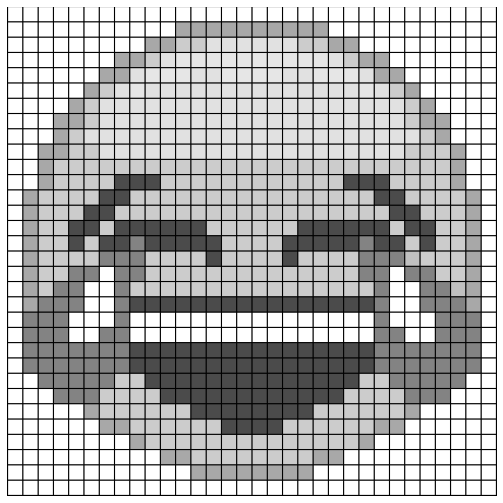

In [33]:
image = tf.io.decode_png(tf.io.read_file('./../pics/01_smile.png'))
image = tf.image.rgb_to_grayscale(image)

plt.imshow(image, cmap='gray')
plt.axis('off')

Прогоним изображение смайла через фильтры:
- вертикальной линии
- горизонтальной линии
- фильтр размытия

In [34]:
# добавим размерность к нашему изображению
input_ = tf.expand_dims(tf.cast(image, tf.float32), 0)
# 3 фильтра с 1 каналом размером 7 столбцов на 7 строк (интерпретация shape справа налево)
filters = np.zeros(shape=(7, 7, 1, 3), dtype=np.float32)

filters[:, 3, :, 0]  = 1  # фильтр вертикальной линии
filters[3, :, :, 1]  = 1  # фильтр горизонтальной линии
filters[:, :, :, 2]  = 1/49  # фильтр размытия
# применями фильтры к входному изображению
outputs = tf.nn.conv2d(input_, filters, strides=1, padding='SAME')
outputs.shape

TensorShape([1, 417, 417, 3])

Визуализируем изображения после прогонки фильтров:

Text(0.5, 1.0, 'blurred')

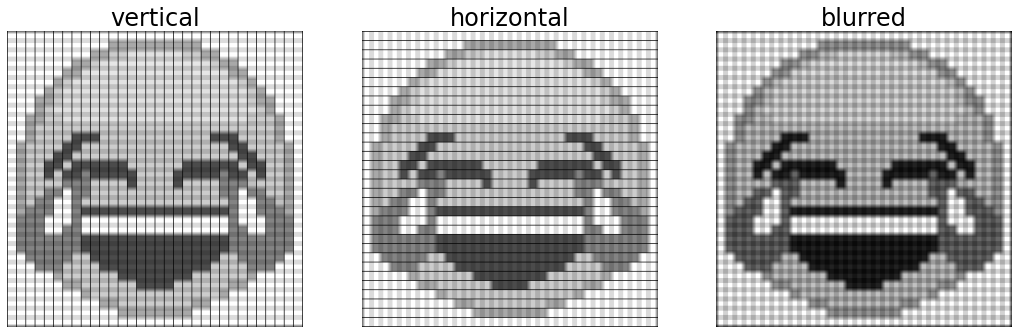

In [35]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(outputs[0, :, :, 0], cmap='gray')
ax[0].axis('off')
ax[0].set_title('vertical')

ax[1].imshow(outputs[0, :, :, 1], cmap='gray')
ax[1].axis('off')
ax[1].set_title('horizontal')

ax[2].imshow(outputs[0, :, :, 2], cmap='gray')
ax[2].axis('off')
ax[2].set_title('blurred')

- фильтр вертикальной линии размыл горизонтальные, но оставил чёткими вертикальные
- фильтр горизонтальной линии размыл вертикальные, но оставил чёткими горизонтальные
- фильтр размытия всё размыл

![](http://go.dialektika.com/images/mlearning/14_05.jpg)

##### Требования к памяти

Входные данные:
- input_shape = (150, 100, 3)
- filters = 200
- kernel_size = (5, 5)
- stride = (1, 1)
- padding = "same"

Расчётные данные:
- количество параметров в свёрточном слое = (5 * 5 * 3 + 1) * 200 = 76 * 200 = 15 200
- количество параметров в полносвязном слое = 150 * 100 * 3 * 150 * 100 = 675 000 000
- количество операций умножения = 200 * 150 * 100 * 5 * 5 * 3 = 225 000 000
- количество памяти на выход свёрточного слоя = 200 * 150 * 100 * 32 = 96 000 000 битов ~ 12 Мбайт

#### Операция пулинга

![](https://i.ibb.co/LSyj00W/nagesh-cnn-intro-8.gif)

![](https://images4.programmersought.com/915/d1/d1cebc590de989b37cf9f520fe58193b.JPEG)

![](http://go.dialektika.com/images/mlearning/14_09.jpg)

### Свёрточные нейронные сети

Свёрточные сети состоят из двух блоков:
- свёрточной основы, она извлекает признаки из изображения
- полносвязного классификатора, ответственного за решение конкретной задачи

![](https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

![](https://miro.medium.com/max/880/1*-9yF-a8gUktDKgRpuNuxNA.png)

#### Задача Fashion MNIST

##### Загрузка данных

In [36]:
(x_trn, y_trn), (x_tst, y_tst) = keras.datasets.fashion_mnist.load_data()

y_trn = y_trn[:, None]
y_tst = y_tst[:, None]

print('x_trn.shape', x_trn.shape)
print('y_trn.shape', y_trn.shape)
print()
print('x_tst.shape', x_tst.shape)
print('y_tst.shape', y_tst.shape)

x_trn.shape (60000, 28, 28)
y_trn.shape (60000, 1)

x_tst.shape (10000, 28, 28)
y_tst.shape (10000, 1)


In [37]:
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

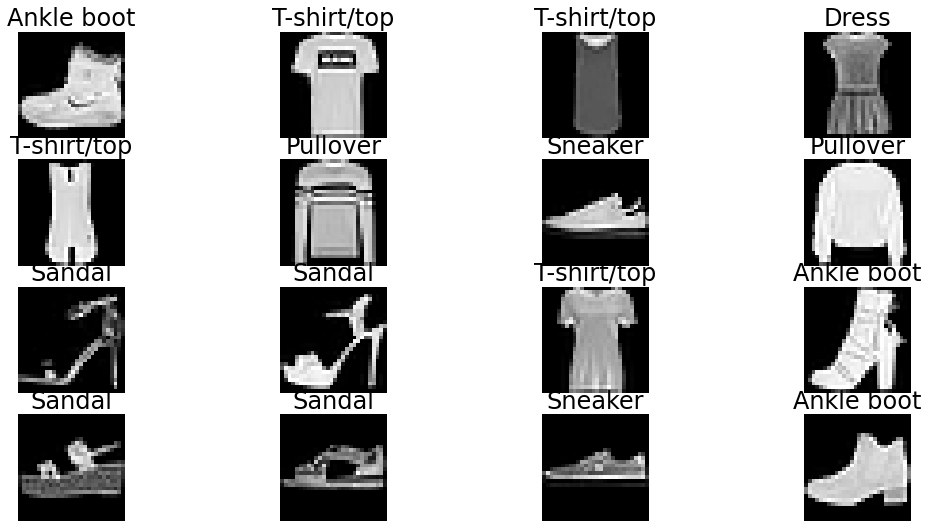

In [38]:
fig, axes = plt.subplots(4, 4)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_trn[i], cmap='gray')
    ax.set_title(class_names[y_trn[i, 0]])
    ax.axis('off')

##### Обработка набора данных

In [39]:
x_trn = x_trn / 255.0
x_tst = x_tst / 255.0

print(x_trn.dtype)
print(x_tst.dtype)

float64
float64


![](https://miro.medium.com/max/2474/1*ggtP4a5YaRx6l09KQaYOnw.png)

In [40]:
y_trn = y_trn.astype(np.float32)
y_tst = y_tst.astype(np.float32)

y_trn = keras.utils.to_categorical(y_trn)
y_tst = keras.utils.to_categorical(y_tst)

print(y_trn.dtype)
print(y_tst.dtype)

float32
float32


Добавим разбиение на проверочные данные

In [41]:
x_trn, x_vld, y_trn, y_vld = train_test_split(x_trn, y_trn, test_size=0.2, stratify=y_trn)

print(x_trn.shape, y_trn.shape)
print(x_vld.shape, y_vld.shape)

(48000, 28, 28) (48000, 10)
(12000, 28, 28) (12000, 10)


In [42]:
x_trn = x_trn[..., None]
x_vld = x_vld[..., None]
x_tst = x_tst[..., None]

print(x_trn.shape)
print(x_vld.shape)
print(x_tst.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


#### Архитектура сети

In [43]:
from functools import partial

In [44]:
Conv2D = partial(layers.Conv2D, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')

In [45]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64))
model.add(Conv2D(filters=64))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32))
model.add(Conv2D(filters=32))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16))
model.add(Conv2D(filters=16))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=[
        metrics.CategoricalAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
    ],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 16)         

In [46]:
history = model.fit(
    x=x_trn,
    y=y_trn,
    batch_size=32,
    epochs=16,
    validation_data=(x_vld, y_vld),
)

Epoch 1/16
1500/1500 [==============================] - 25s 5ms/step - loss: 2.1186 - accuracy: 0.2085 - precision: 0.3920 - recall: 0.0394 - val_loss: 0.7754 - val_accuracy: 0.7184 - val_precision: 0.8594 - val_recall: 0.5599
Epoch 2/16
1500/1500 [==============================] - 7s 5ms/step - loss: 0.9713 - accuracy: 0.6414 - precision: 0.7820 - recall: 0.4920 - val_loss: 0.6102 - val_accuracy: 0.7594 - val_precision: 0.8649 - val_recall: 0.6759
Epoch 3/16
1500/1500 [==============================] - 7s 5ms/step - loss: 0.7680 - accuracy: 0.7184 - precision: 0.8325 - recall: 0.6006 - val_loss: 0.5304 - val_accuracy: 0.7895 - val_precision: 0.8786 - val_recall: 0.7236
Epoch 4/16
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6783 - accuracy: 0.7495 - precision: 0.8516 - recall: 0.6487 - val_loss: 0.4867 - val_accuracy: 0.8097 - val_precision: 0.9033 - val_recall: 0.7259
Epoch 5/16
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6186 - accuracy: 

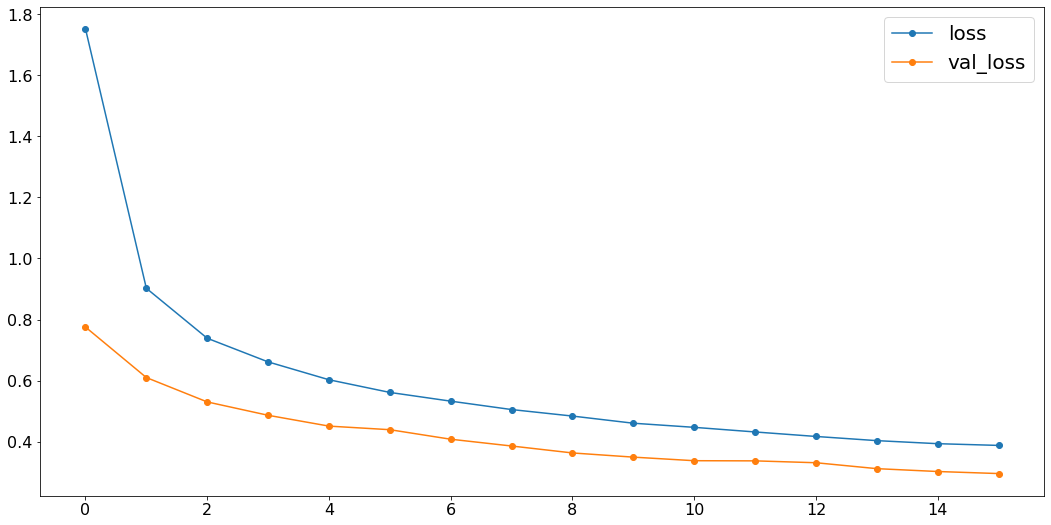

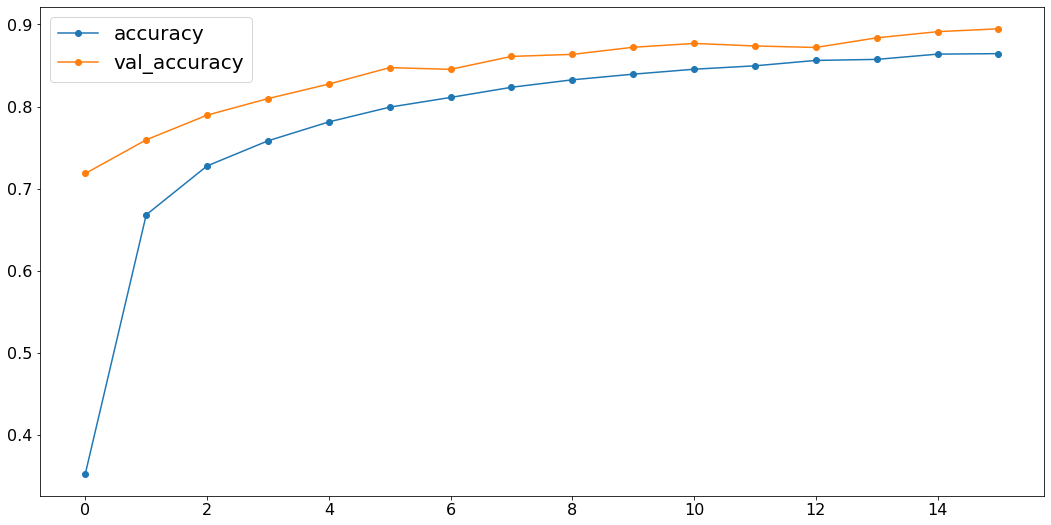

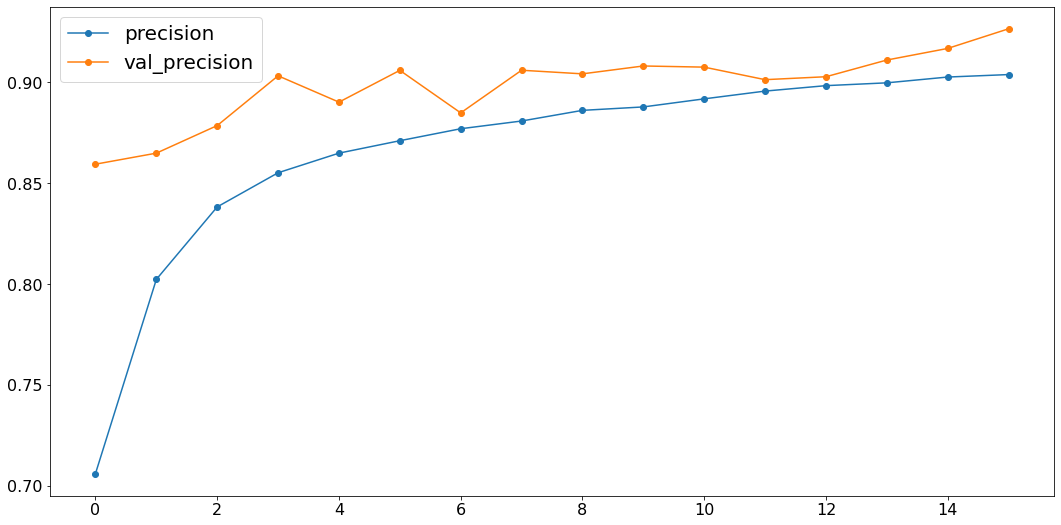

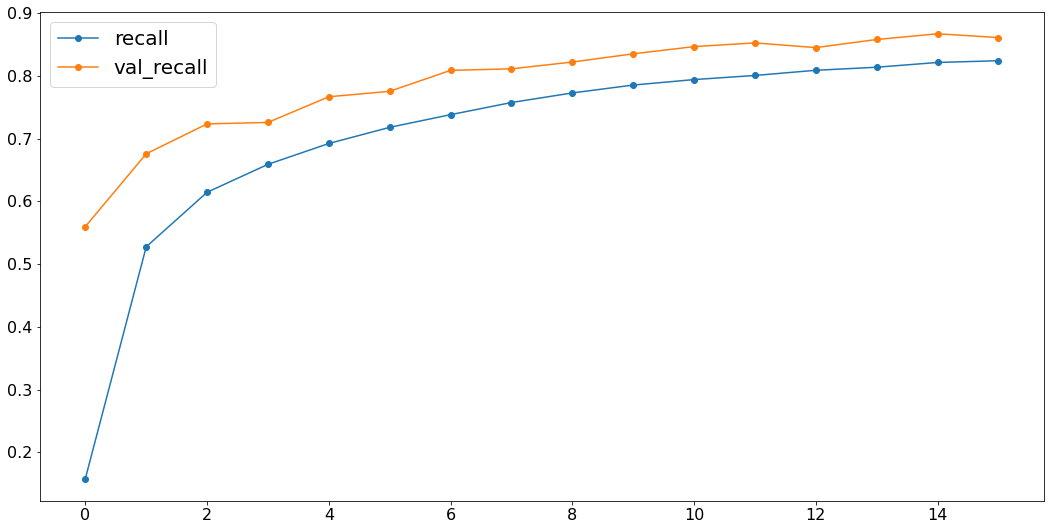

In [47]:
history_df = pd.DataFrame(history.history)

for metric in list(history.history.keys())[:4]:
    history_df[[metric, 'val_'+metric]].plot(style='-o', figsize=(18, 9), fontsize=16)

In [48]:
model.evaluate(x_tst, y_tst)

313/313 [==============================] - 9s 27ms/step - loss: 0.3268 - accuracy: 0.8831 - precision: 0.9134 - recall: 0.8484


[0.32683664560317993,
 0.8830999732017517,
 0.9134367108345032,
 0.8483999967575073]

Если сравнивать с полносвязной сетью из предыдущего митапа, то здесь у нас в 3.5 раза меньше параметров, а вот accuarcy и precision стали лучше. Это говорит о лучшей приспособленности свёрточных нейронных сетей к задачам классификации изображений.

### Визуализация знаний, заключённых в сверточной нейронной сети

**в случае полносвязных НС, можно визуализировать веса**

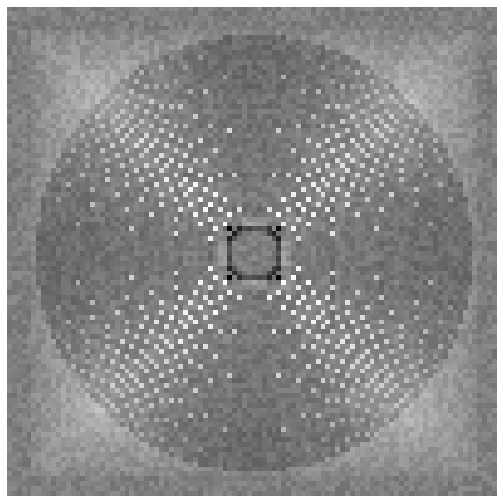

**визуализация карт признаков**

[2D Visualization of a Convolution Neural Network](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)

**визуализация методом градиентного восхождения в пространстве входов**

[How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

![](https://blog.keras.io/img/vgg16_filters_overview.jpg)
![](https://4.bp.blogspot.com/-tTYZpdJ18bg/VYITAO4s_uI/AAAAAAAAAlE/L7VMImFFt_M/s640/noise-to-banana.png)

**DeepDream**

![](https://4.bp.blogspot.com/-FPDgxlc-WPU/VYIV1bK50HI/AAAAAAAAAlw/YIwOPjoulcs/s1600/skyarrow.png)
![](https://3.bp.blogspot.com/-R15_fyB-ZpE/VYIV-Uu9iwI/AAAAAAAAAl4/o3heQNGpVRU/s640/Funny-Animals.png)

**визуализация тепловых карт активации класса**

Shuttle | Dog
- | - 
![alt](https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_gradcam_space_shuttle.png) | ![alt](https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_gradcam_beagle.png)

### Adversarial attacks

![](https://hsto.org/getpro/habr/post_images/091/42d/a2b/09142da2b2212331a994cd5b6b006205.png)

![](https://miro.medium.com/max/4000/1*PmCgcjO3sr3CPPaCpy5Fgw.png)

![](https://www.cse.gatech.edu/sites/cse.gatech.edu/files/images/mercury/shapeshifterimg.png)

![](./../pics/02_adversarial_attack_alexa.png)

[Tesla Burger King Stop Sign](https://www.youtube.com/watch?v=jheBCOpE9ws)